In [89]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import torch

import sys
sys.path.insert(0, '../fem')
from datasaver import *

import sys
sys.path.insert(0, '../ml')
from modelloader import loadmodelfromlabel
from NGO import NGO

In [90]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
from VarMiON import VarMiON
from RegularNN import RegularNN
from NGO import NGO

logdir = '../../../nnlogs'
map_location = 'cpu'

sublogdir = 'POD'
BSGNGO = loadmodelfromlabel(model=NGO, label='BS G-NGO', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
PODGNGO = loadmodelfromlabel(model=NGO, label='POD G-NGO', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
BSPODPGNGO = loadmodelfromlabel(model=NGO, label='BS-POD PG-NGO', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
PODBSPGNGO = loadmodelfromlabel(model=NGO, label='POD-BS PG-NGO', logdir=logdir, sublogdir=sublogdir, map_location=map_location)


modeldict = {'BS G': BSGNGO,
             'POD G': PODGNGO,
             'BS-POD PG': BSPODPGNGO,
             'POD-BS PG': PODBSPGNGO}

In [92]:
#Test dataset
N_samples = 1000
theta_test = load_function_list('theta', '../../../trainingdata/VarMiONpaperdata/test')[:N_samples]
f_test = load_function_list('f', '../../../trainingdata/VarMiONpaperdata/test')[:N_samples]
etab_test = load_function_list('etab', '../../../trainingdata/VarMiONpaperdata/test')[:N_samples]
etat_test = load_function_list('etat', '../../../trainingdata/VarMiONpaperdata/test')[:N_samples]
x_test = np.load('../../../trainingdata/VarMiONpaperdata/test/x.npy')[:N_samples]
u_test = np.load('../../../trainingdata/VarMiONpaperdata/test/u.npy')[:N_samples]

FEM BS G
FEM POD G
FEM BS-POD PG
FEM POD-BS PG


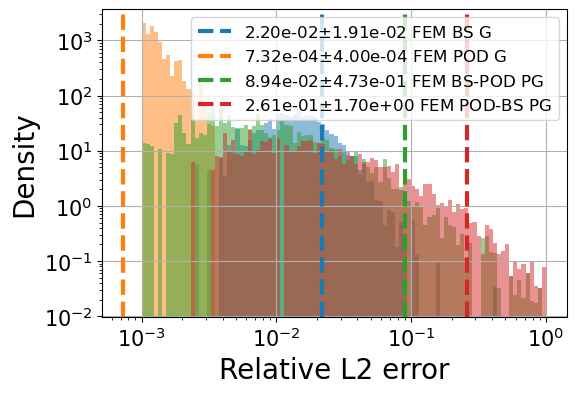

In [88]:
size_title = 20
size_ticklabels = 15
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
plotlabels = ['BS G-NGO', 'POD G-NGO', 'BS-POD PG-NGO', 'POD-BS PG-NGO']
j=0
for model in modeldict:
    print(str(model))
    if str(model).startswith('FEM')==True:
        u_hat = modeldict[str(model)].simforward_FEM(theta_test, f_test, etab_test, etat_test, x_test)
    else:
        u_hat = modeldict[str(model)].simforward(theta_test, f_test, etab_test, etat_test, x_test)
    L2 = torch.norm(torch.tensor(u_hat) - torch.tensor(u_test), p=2, dim=-1)
    norm = torch.norm(torch.tensor(u_test), p=2, dim=-1)
    L2_scaled = (L2/norm)
    L2_scaled = L2_scaled.detach().numpy()
    L2_scaled_avg = np.average(L2_scaled)
    sigma = np.std(L2_scaled)
    ax.hist(L2_scaled, bins=np.logspace(-3,0,100), density=True, alpha=0.5, linewidth=1, color=colors[j], histtype='bar')
    ax.axvline(L2_scaled_avg, 0, 1, linewidth=3, linestyle='--', color=colors[j], label=format(L2_scaled_avg, f".{2}e")+r'$\pm$'+format(sigma, f".{2}e")+' '+str(model))
    j+=1
ax.legend(fontsize=12)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'Relative L2 error', fontsize=size_axeslabels)
ax.set_ylabel(r'Density', fontsize=size_axeslabels)
ax.grid()
ax.set_xscale('log')
ax.set_yscale('log')

plt.savefig("allFEMs.svg", bbox_inches='tight')